In [1]:
# Staked Regressions to predict House Price
### https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard/data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from scipy.stats import norm, skew
from subprocess import check_output

%matplotlib inline
color = sns.color_palette()
sns.set_style('darkgrid')

# ignore annoying warning 
def ignore_warn(*agrs, **kwargs):
    pass
warnings.warn = ignore_warn

# limits floats output to 3 decimal points
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

# check files available in the directory
print(check_output(["ls", "./data"]).decode("utf8"))


data_description.txt
sample_submission.csv
test.csv
train.csv



In [2]:
# imports train/test data
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [3]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
# check data size and features
print("*** Before dropping ID feature")
print("Train data size: {}".format(train.shape))
print("Test data size: {}".format(test.shape))

# drop 'ID' column
train_ID = train["Id"]
test_ID = test["Id"]
train.drop("Id", axis=1, inplace=True)
test.drop("Id", axis=1, inplace=True)
print("*** After dropping ID feature")
print("Train data size: {}".format(train.shape))
print("Test data size: {}".format(test.shape))

*** Before dropping ID feature
Train data size: (1460, 81)
Test data size: (1459, 80)
*** After dropping ID feature
Train data size: (1460, 80)
Test data size: (1459, 79)


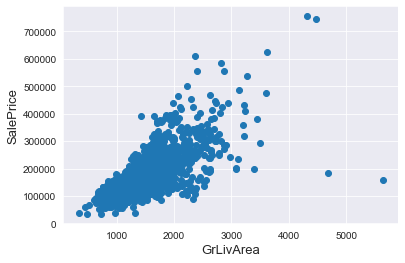

In [6]:
# 1. Data Processing

### Outliers
# explore outliers
fig, ax = plt.subplots()
ax.scatter(x=train['GrLivArea'], y=train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

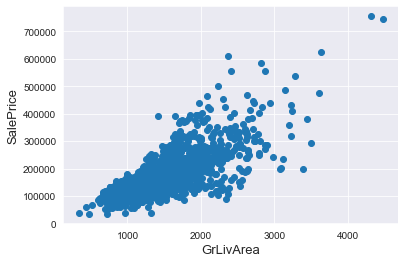

In [7]:
# delete outliers seen at the bottom right
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
fig, ax = plt.subplots()
ax.scatter(x=train['GrLivArea'], y=train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()


In [8]:
# Note: Author said removing all outliers in the training data may affect badly models if ever there were also outliers in the test data


 mu=180932.92 and sigma=79467.79



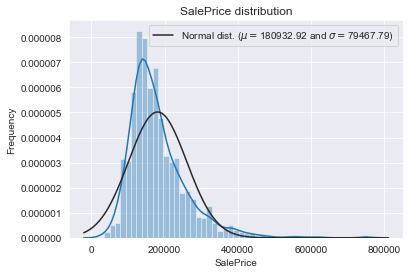

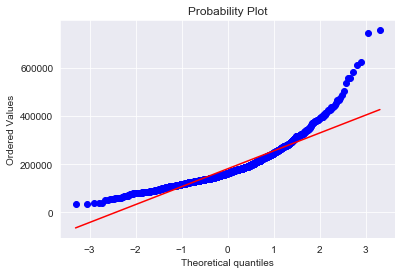

In [9]:
### Target Variable: SalePrice
# check distribution of target variable
sns.distplot(train['SalePrice'], fit=norm);
(mu, sigma) = norm.fit(train['SalePrice'])
print('\n mu={:.2f} and sigma={:.2f}\n'.format(mu,sigma))
plt.legend(['Normal dist. ($\mu=${:.2f} and $\sigma=${:.2f})'.format(mu,sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

In [10]:
# Note: The target variable is right skewed. We need to make it more normally distributed which is favorable to linear model.


 mu=12.02 and sigma=0.40



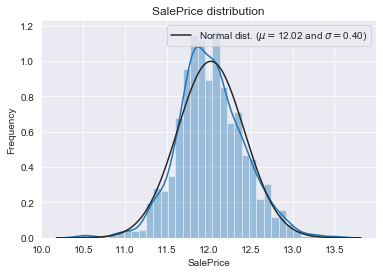

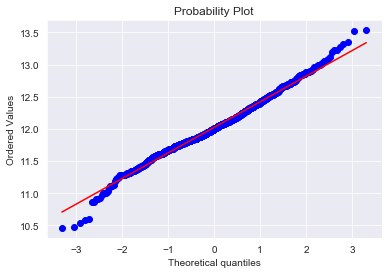

In [11]:
# Log-transformation of the target variables
train['SalePrice'] = np.log1p(train['SalePrice']) ## log(1+x)
sns.distplot(train['SalePrice'], fit=norm);
(mu, sigma) = norm.fit(train['SalePrice'])
print('\n mu={:.2f} and sigma={:.2f}\n'.format(mu,sigma))
plt.legend(['Normal dist. ($\mu=${:.2f} and $\sigma=${:.2f})'.format(mu,sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()


In [12]:
# 2. Feature Engineering
# concatenate the train and test data in the same dataframe
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train,test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size: {}".format(all_data.shape))

all_data size: (2917, 79)


In [13]:
### Missing Data
all_data_na = (all_data.isnull().sum() / len(all_data))*100
all_data_na = all_data_na.drop(all_data_na[all_data_na==0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' : all_data_na})
missing_data

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageQual,5.451
GarageCond,5.451
GarageFinish,5.451
GarageYrBlt,5.451


Text(0.5, 1.0, 'Percent of missing data by features')

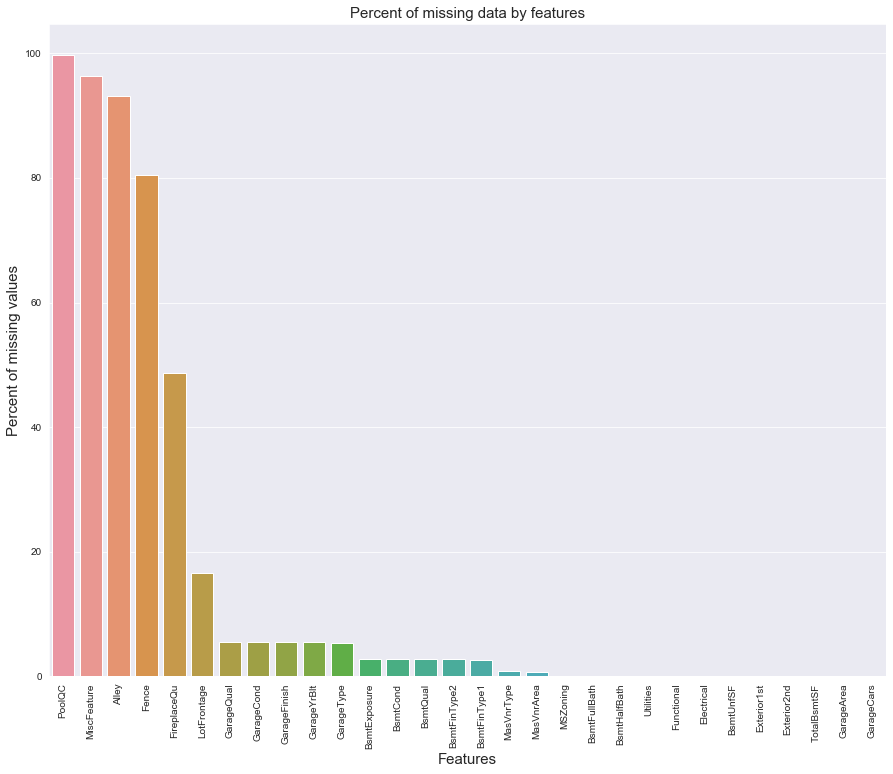

In [14]:
f, ax = plt.subplots(figsize=(15,12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent of missing data by features', fontsize=15)

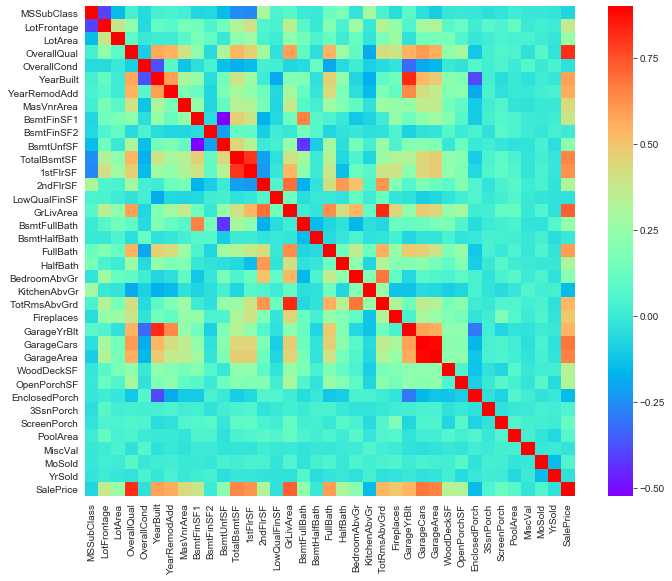

In [15]:
### Data Correlation
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True, cmap='rainbow')

In [16]:
### Imputing missing values

all_data.columns
# fill in missing values by the median LotFrontage of the neighborhood
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median())) 

# fill by "None"
for col in ('PoolQC','MiscFeature','Alley','Fence','FireplaceQu',
            'GarageType','GarageFinish','GarageQual','GarageCond',
            'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
            'MasVnrType', 'MSSubClass'):
    all_data[col] = all_data[col].fillna("None")
    
# fill by 0
for col in ('GarageYrBlt','GarageArea','GarageCars',
            'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
            'MasVnrArea'):
    all_data[col] = all_data[col].fillna(0)
    
# fill by the most common value
for col in ('MSZoning', 'Electrical', 'KitchenQual', 
            'Exterior1st', 'Exterior2nd', 'SaleType'):
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

all_data['Functional'] = all_data['Functional'].fillna("Typ")
all_data = all_data.drop(['Utilities'], axis=1)


In [17]:
all_data_na = (all_data.isnull().sum() / len(all_data))*100
all_data_na = all_data_na.drop(all_data_na[all_data_na==0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' : all_data_na})
missing_data

,Missing Ratio


In [18]:
### More features engineering
# transforms some numerical variables that are really categorical
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [19]:
# transforms non-numerical labels to numerical labels
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 
        'BsmtFinType1', 'BsmtFinType2', 'Functional', 'Fence', 
        'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 
        'MSSubClass', 'OverallCond', 'YrSold', 'MoSold')
for c in cols:
    lbl = LabelEncoder()
    lbl.fit(list(all_data[c].values))
    all_data[c] = lbl.transform(list(all_data[c].values))
    
print('Shape of all_data: {}'.format(all_data.shape))
all_data.head(5)

Shape of all_data: (2917, 78)


,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleCondition,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,1,3,1Fam,4,3,706.000,0.000,...,Normal,WD,0,1,8,856.000,0,2003,2003,2
1,1262,0,0,1,3,1Fam,4,1,978.000,0.000,...,Normal,WD,0,1,6,1262.000,298,1976,1976,1
2,920,866,0,1,3,1Fam,4,2,486.000,0.000,...,Normal,WD,0,1,6,920.000,0,2001,2002,2
3,961,756,0,1,3,1Fam,1,3,216.000,0.000,...,Abnorml,WD,0,1,7,756.000,0,1915,1970,0
4,1145,1053,0,1,4,1Fam,4,0,655.000,0.000,...,Normal,WD,0,1,9,1145.000,192,2000,2000,2


In [20]:
# adds one more feature: total sqfootage
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [21]:
# skewed features
# Pearson skewness = (mean-mode)/σ
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("Skew in numerical features:")
skewness = pd.DataFrame({'Skew': skewed_feats})
skewness.shape

Skew in numerical features:


(59, 1)

In [22]:
skewness[abs(skewness) > 0.75].count()

Skew    36
dtype: int64

In [23]:
# Box Cox transformation of highly skewed features
from scipy.special import boxcox1p

skew_high = skewness[abs(skewness) > 0.75]
skewed_features = skew_high.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
skewed_feats_mod = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness_mod = pd.DataFrame({'Skew': skewed_feats_mod})
skewness_mod[abs(skewness_mod)>0.75].count()

Skew    38
dtype: int64

Text(0.5, 1.0, 'Skewness comparison after transformation')

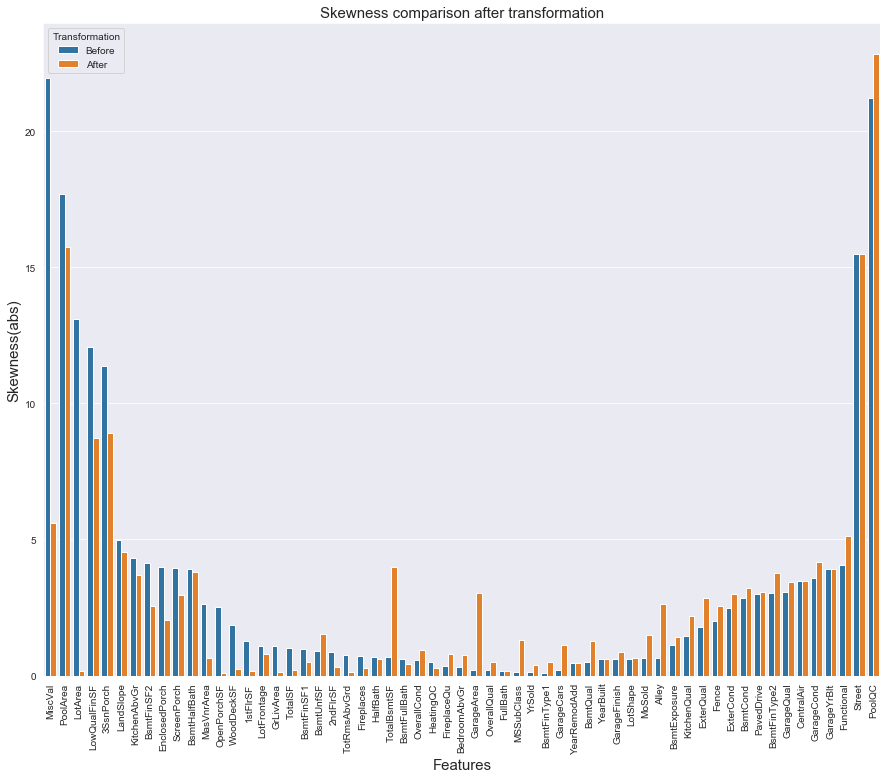

In [24]:
skew_before = pd.DataFrame({'Index': skewed_feats.index, 'Skewness': abs(skewed_feats), 'Transformation': ["Before" for i in range(len(skewed_feats))]})
skew_after  = pd.DataFrame({'Index': skewed_feats_mod.index,'Skewness': abs(skewed_feats_mod), 'Transformation': ["After" for i in range(len(skewed_feats_mod))]})
skew_compare = pd.merge(skew_before, skew_after, how='outer')

f, ax = plt.subplots(figsize=(15,12))
sns.barplot(x="Index", y="Skewness", hue="Transformation", data=skew_compare)
plt.xticks(rotation='90')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Skewness(abs)', fontsize=15)
plt.title('Skewness comparison after transformation', fontsize=15)


In [25]:
# Note: transformation seems to rotate right-skewed data to leftwise   

In [26]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)
all_data.head(5)

(2917, 220)


,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,...,SaleCondition_Partial,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
0,11.693,11.686,0.000,0.730,1.541,1.820,1.541,11.170,0.000,1.194,...,0,0,0,0,0,0,0,0,0,1
1,12.792,0.000,0.000,0.730,1.541,1.820,0.730,12.063,0.000,0.000,...,0,0,0,0,0,0,0,0,0,1
2,11.892,11.725,0.000,0.730,1.541,1.820,1.194,10.200,0.000,1.194,...,0,0,0,0,0,0,0,0,0,1
3,12.014,11.354,0.000,0.730,1.541,0.730,1.541,8.274,0.000,0.000,...,0,0,0,0,0,0,0,0,0,1
4,12.511,12.271,0.000,0.730,1.820,1.820,0.000,10.971,0.000,1.194,...,0,0,0,0,0,0,0,0,0,1


In [27]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [28]:
# 3. Modeling
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

### Validation function
n_folds = 5
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(model, train.values, y_train, scoring='neg_mean_squared_error', cv=kf))
    return rmse

### Base models
# 1) LASSO Regression
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))
# 2) Elastic Net Regression
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
# 3) Kernel Ridge Regression
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
# 4) Gradient Boosting Regression
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, 
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state=5)
# 5) XGBoost
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, learning_rate=0.05,
                             max_depth=3, min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571, subsample=0.5213,
                             silent=1, random_state=7, nthread=-1)
# 6) LightGBM
model_lgb = lgb.LGBMRegressor(objective='regression', num_leaves=5, learning_rate=0.05,
                              n_estimators=720, max_bin=55, bagging_fraction=0.8,
                              bagging_freq=5, feature_fraction=0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf=6, min_sum_hessian_in_leaf=11)

In [29]:
print("Model Mean Std.")
print("---------------")
score = rmsle_cv(lasso)
print("Lasso: {:.4f} ({:.4f})".format(score.mean(), score.std()))
score = rmsle_cv(ENet)
print("ElasticNet: {:.4f} ({:.4f})".format(score.mean(), score.std()))
score = rmsle_cv(KRR)
print("KernelRidge: {:.4f} ({:.4f})".format(score.mean(), score.std()))
score = rmsle_cv(GBoost)
print("GradientBoosting: {:.4f} ({:.4f})".format(score.mean(), score.std()))
score = rmsle_cv(model_xgb)
print("Xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
score = rmsle_cv(model_lgb)
print("LGBM: {:.4f} ({:.4f})".format(score.mean(), score.std()))


Model Mean Std.
---------------
Lasso: 0.1115 (0.0074)
ElasticNet: 0.1116 (0.0074)
KernelRidge: 0.1153 (0.0075)
GradientBoosting: 0.1177 (0.0080)
Xgboost: 0.1151 (0.0072)
LGBM: 0.1162 (0.0071)


In [30]:
# 4. Stacking models
### Averaging base models
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
    
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        for model in self.models_:
            model.fit(X, y)
        return self
    
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(predictions, axis=1)
    
averaged_models = AveragingModels(models=(ENet, GBoost, KRR, lasso))
score = rmsle_cv(averaged_models)
print("Averaged base model: {:.4f} ({:.4f})".format(score.mean(), score.std()))


Averaged base model: 0.1091 (0.0075)


In [34]:
### Meta-model added models
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
    
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X,y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
    
    def predict(self, X):
        meta_features = np.column_stack([ np.column_stack([model.predict(X) for model in base_models]).mean(axis=1) 
                                          for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)
    
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR), meta_model=lasso)
score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models: 0.1085 (0.0074)


In [35]:
### Ensembling StackedRegressor, XGBoost and LightGBM
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

print("Trining error")
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print("StackedRegressor: {}".format(rmsle(y_train, stacked_train_pred)))

model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print("XGBoost: {}".format(rmsle(y_train, xgb_train_pred)))

model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print("LightGBM: {}".format(rmsle(y_train, lgb_train_pred)))
## numpy.expm1(x): Calculate exp(x) - 1 for all elements in the array

ensemble_rmsle_train = rmsle(y_train, stacked_train_pred*0.70 + xgb_train_pred*0.15 + lgb_train_pred*0.15)
print('RMSLE score on train data:{}'.format(ensemble_rmsle_train))

ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)


Trining error
StackedRegressor: 0.07803882799654997
XGBoost: 0.07894559653917806
LightGBM: 0.07307464036005418
RMSLE score on train data:0.07540370048505313


In [37]:
sub.head(5)

,Id,SalePrice
0,1461,119846.591
1,1462,160782.649
2,1463,187198.169
3,1464,196720.099
4,1465,193085.590



 mu=178557.30 and sigma=78252.69



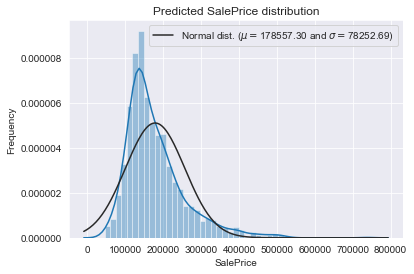

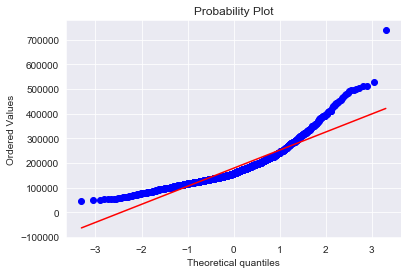

In [38]:
sns.distplot(sub['SalePrice'], fit=norm);
(mu, sigma) = norm.fit(sub['SalePrice'])
print('\n mu={:.2f} and sigma={:.2f}\n'.format(mu,sigma))
plt.legend(['Normal dist. ($\mu=${:.2f} and $\sigma=${:.2f})'.format(mu,sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('Predicted SalePrice distribution')

# QQ-plot
fig = plt.figure()
res = stats.probplot(sub['SalePrice'], plot=plt)
plt.show()